Compare the current best model (`alexnet_based_extra_convlayer`) with the model based on it but with saturating epoch set to 100 (slower decay for the learning rate).

In [2]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import holoviews as hl
#%load_ext holoviews.ipython
import sklearn.metrics

In [3]:
cd ..

/afs/inf.ed.ac.uk/user/s13/s1320903/Neuroglycerin/neukrill-net-work


Load the current best model. Plot parameters.

In [5]:
model = pylearn2.utils.serial.load('/disk/scratch/neuroglycerin/models/alexnet_based_extra_convlayer.pkl')

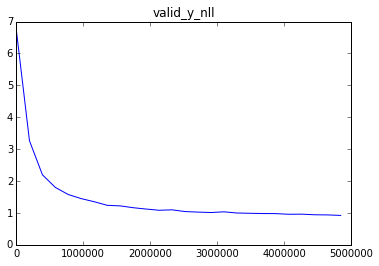

In [16]:
def plot_monitor(c):
    channel = model.monitor.channels[c]
    plt.title(c)
    plt.plot(channel.example_record,channel.val_record)
    return None
plot_monitor("valid_y_nll")

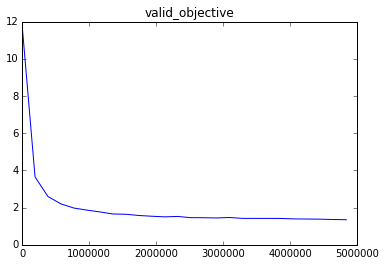

In [17]:
plot_monitor(c="valid_objective")

Go on a free core.

In [19]:
%env $THEANO_FLAGS = device=gpu2,floatX=float32,base_compiledir=~/.theano/stonesoup2

env: $THEANO_FLAGS=device=gpu2,floatX=float32,base_compiledir=~/.theano/stonesoup2


Remind myself of the best model's score.

In [21]:
%run check_test_score.py run_settings/alexnet_based_extra_convlayer.json

Log loss: 0.808881965028


Check the model we are running right now. It already saw 5 million samples (the same as the original model) so let's compare.

In [22]:
%run check_test_score.py -v run_settings/alexnet_extra_layer_learning_rate.json

Loading settings..
Loading model...
Loading data...
Applying normalisation: global
Finding batch size...
    chosen batch size 3089 for 8 batches
Compiling forward prop...
Making predictions...
    Batch 1 of 8
    Batch 2 of 8
    Batch 3 of 8
    Batch 4 of 8
    Batch 5 of 8
    Batch 6 of 8
    Batch 7 of 8
    Batch 8 of 8
Collapsing predictions...
Log loss: 0.864401240836


Not as good. But the learning rate will keep decaying until epoch 100, and it's only epoch 37 now...Let it train.

Some plots of the currently trained model.

In [23]:
model = pylearn2.utils.serial.load('/disk/scratch/neuroglycerin/models/alexnet_extra_layer_learning_rate.pkl')

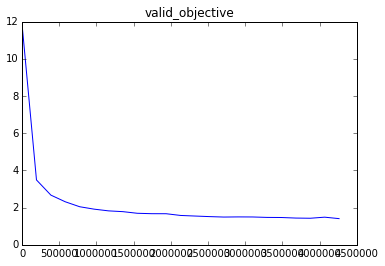

In [24]:
plot_monitor(c="valid_objective")

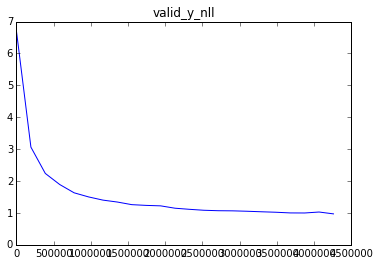

In [25]:
plot_monitor(c="valid_y_nll")

A new best pkl was saved. Check it:

In [26]:
%run check_test_score.py -v run_settings/alexnet_extra_layer_learning_rate.json

Loading settings..
Loading model...
Loading data...
Applying normalisation: global
Finding batch size...
    chosen batch size 3089 for 8 batches
Compiling forward prop...
Making predictions...
    Batch 1 of 8
    Batch 2 of 8
    Batch 3 of 8
    Batch 4 of 8
    Batch 5 of 8
    Batch 6 of 8
    Batch 7 of 8
    Batch 8 of 8
Collapsing predictions...
Log loss: 0.855427228866


A little better. Why don't we check the most recent pkl too? Need to change the check_score function to do this.

In [43]:
import numpy as np
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import sklearn.metrics
import argparse
import os

def check_score(run_settings_path, recent_path, verbose=False):
    """
    Single function, calculates score, prints and
    returns it.
    """
    # load settings
    if verbose:
        print("Loading settings..")
    settings = neukrill_net.utils.Settings("settings.json")
    run_settings = neukrill_net.utils.load_run_settings(run_settings_path, 
            settings, force=True)
    
    # load the model
    if verbose:
        print("Loading model...")
    if not recent_path:
        recent_path=run_settings['pickle abspath']
    model = pylearn2.utils.serial.load(recent_path)

    # load the data
    if verbose:
        print("Loading data...")
    dataset = neukrill_net.dense_dataset.DensePNGDataset(
            settings_path=run_settings['settings_path'],
            run_settings=run_settings['run_settings_path'],
            train_or_predict='train',
            training_set_mode='test', force=True, verbose=verbose)

    # find a good batch size 
    if verbose:
        print("Finding batch size...")
    batch_size = 500
    while dataset.X.shape[0]%batch_size != 0:
        batch_size += 1
    n_batches = int(dataset.X.shape[0]/batch_size)
    if verbose:
        print("    chosen batch size {0}"
                " for {1} batches".format(batch_size,n_batches))

    # compiling theano forward propagation
    if verbose:
        print("Compiling forward prop...")
    model.set_batch_size(batch_size)
    X = model.get_input_space().make_batch_theano()
    Y = model.fprop(X)
    f = theano.function([X],Y)

    # compute probabilities
    if verbose:
        print("Making predictions...")
    y = np.zeros((dataset.X.shape[0],len(settings.classes)))
    for i in xrange(n_batches):
        if verbose:
            print("    Batch {0} of {1}".format(i+1,n_batches))
        x_arg = dataset.X[i*batch_size:(i+1)*batch_size,:]
        if X.ndim > 2:
            x_arg = dataset.get_topological_view(x_arg)
        y[i*batch_size:(i+1)*batch_size,:] = (f(x_arg.astype(X.dtype).T))

    # find augmentation factor
    af = run_settings.get("augmentation_factor",1)
    if af > 1:
        if verbose:
            print("Collapsing predictions...")
        y_collapsed = np.zeros((int(dataset.X.shape[0]/af), len(settings.classes))) 
        for i,(low,high) in enumerate(zip(range(0,dataset.y.shape[0],af),
                                    range(af,dataset.y.shape[0]+af,af))):
            y_collapsed[i,:] = np.mean(y[low:high,:], axis=0)
        y = y_collapsed
        # and collapse labels
        labels = dataset.y[range(0,dataset.y.shape[0],af)]
    else:
        labels = dataset.y

    # calculate score
    logloss = sklearn.metrics.log_loss(labels,y)
    print("Log loss: {0}".format(logloss))

    return logloss

Run it:

In [45]:
check_score('run_settings/alexnet_extra_layer_learning_rate.json', '/disk/scratch/neuroglycerin/models/alexnet_extra_layer_learning_rate.pkl.recent') 

Loading settings..
Loading model...
Loading data...
Applying normalisation: global
Finding batch size...
    chosen batch size 3089 for 8 batches
Compiling forward prop...
Making predictions...
    Batch 1 of 8
    Batch 2 of 8
    Batch 3 of 8
    Batch 4 of 8
    Batch 5 of 8
    Batch 6 of 8
    Batch 7 of 8
    Batch 8 of 8
Collapsing predictions...
Log loss: 0.828623822063


0.82862382206277641

The best current pkl:

In [47]:
%run check_test_score.py -v run_settings/alexnet_extra_layer_learning_rate.json

Loading settings..
Loading model...
Loading data...
Applying normalisation: global
Finding batch size...
    chosen batch size 3089 for 8 batches
Compiling forward prop...
Making predictions...
    Batch 1 of 8
    Batch 2 of 8
    Batch 3 of 8
    Batch 4 of 8
    Batch 5 of 8
    Batch 6 of 8
    Batch 7 of 8
    Batch 8 of 8
Collapsing predictions...
Log loss: 0.811846951148
